# Importar Bibliotecas Necessárias

In [9]:
# Importar as bibliotecas

# -*- coding: utf-8 -*-

import numpy as np
from timeit import default_timer as timer
import random
import serial
import serial.tools.list_ports
import os
from math import sqrt
import argparse
import matplotlib as plt
import pandas as pd
import tensorflow as tf

from datetime import datetime
from scipy.fft import fft

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

# https://www.linkedin.com/pulse/lendo-arquivos-csv-com-pandas-rog%C3%A9rio-guimar%C3%A3es-de-campos-j%C3%BAnior/
# https://stackabuse.com/python-list-files-in-a-directory/

C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ander\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

# Rede MLP

In [10]:
# Carregar dados MPL para modelo RNN

# Definição do paciente e os diretórios
nome = "Anderson_CH1_MSE"

# Caminho dos dados
filename = f"Dataset\\{nome}\\dados_classificacao.csv"
filename_limiar = f"Dataset\\{nome}\\limiar.txt"
filename_movimentos = f"Dataset\\{nome}\\movimentos_classificacao.csv"

In [11]:
# Transforma de str para float

def str2float(Part):
    for i in range(0, len(Part)):
        Part[i] = Part[i].split(';')
        for j in range(0, len(Part[i])):
            Part[i][j] = float(Part[i][j].replace(',', '.'))

    return Part

In [12]:
# Calcula: RMS 

def f_rms(dado, segments):
    Vrms = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    for s in range(0, segments): 
        soma = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
            soma = soma + (dado[sample] ** 2) 

        Vrms.append(sqrt(soma/segment))
        aux = aux_2 - 1

    return Vrms

In [13]:
# Detecta o impulso baseado no ruído em repouso do músculo
def delta_dirac(data_full, filename_limiar, N, janela):
    # Valor obtido empiricamente utilizando o repouso
    with open(filename_limiar, 'r') as l:
        limiar = l.read()
    
    limiar = float(limiar)
    segments = 1
    
    # Compara se algum dos valores é maior que o limiar, caso sim efetua o RMS
    # dos próximos 40 pontos (baseado em Rodrigo Ortolan)
    # Se o RMS desses 40 pontos for maior que o limiar considera este o inicio da contração 
    # E retorna 400 pontos referentes aos 200ms do começo do sinal
    for row in range(0, len(data_full)):
        if data_full[row] > limiar:
            rms = f_rms(data_full[row:(row + janela)], segments)
            if (rms[0]) > limiar:
                #print (row)
                data_part = data_full[row:(row + N)]
                
                return data_part

In [14]:
lines = []
y = []
qty_lines = 80

with open(filename, 'r') as f:
    for i in range(0, qty_lines):
        lines.append(f.readline())
        
with open(filename_movimentos, 'r') as f:
    for i in range(0, qty_lines):
        read_data = f.readline()
        read_data = list(read_data.split(';'))
        for j in range(0, len(read_data)):
            read_data[j] = int(read_data[j])
        y.append(read_data)

lines = str2float(lines)

#display(lines[0])
display(y[0])

[0]

In [15]:
# Definição de parâmetros para obtenção dos 200ms
N = 400
janela = 10 # janela flexão e extensao = 10

Part = []
i = 0

for line in lines:
    #print (i)
    det = delta_dirac(line, filename_limiar, N, janela) 
    if (det != None):
        Part.append(det)
    else:
        y[i] = -1
    i += 1

# display(len(y))

while (-1 in y):
    y.remove(-1)

In [16]:
# Normalização dos dados
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
Part_normalize = scaler.fit_transform(Part)

display(Part[74])
display(Part_normalize[74])

[1.85,
 1.86,
 1.87,
 1.88,
 1.88,
 1.87,
 1.88,
 1.88,
 1.87,
 1.87,
 1.86,
 1.87,
 1.85,
 1.81,
 1.78,
 1.74,
 1.72,
 1.69,
 1.67,
 1.66,
 1.68,
 1.69,
 1.72,
 1.74,
 1.77,
 1.78,
 1.79,
 1.81,
 1.83,
 1.84,
 1.84,
 1.85,
 1.84,
 1.84,
 1.82,
 1.81,
 1.79,
 1.79,
 1.78,
 1.78,
 1.78,
 1.76,
 1.76,
 1.77,
 1.78,
 1.81,
 1.82,
 1.82,
 1.83,
 1.84,
 1.83,
 1.8,
 1.81,
 1.82,
 1.83,
 1.83,
 1.83,
 1.85,
 1.85,
 1.85,
 1.83,
 1.82,
 1.81,
 1.79,
 1.69,
 1.74,
 1.74,
 1.73,
 1.73,
 1.74,
 1.74,
 1.74,
 1.73,
 1.76,
 1.76,
 1.78,
 1.79,
 1.81,
 1.81,
 1.82,
 1.81,
 1.81,
 1.81,
 1.82,
 1.8,
 1.8,
 1.79,
 1.8,
 1.8,
 1.79,
 1.78,
 1.8,
 1.82,
 1.83,
 1.82,
 1.82,
 1.83,
 1.79,
 1.8,
 1.8,
 1.81,
 1.82,
 1.81,
 1.82,
 1.8,
 1.8,
 1.8,
 1.81,
 1.81,
 1.83,
 1.81,
 1.81,
 1.8,
 1.82,
 1.81,
 1.8,
 1.8,
 1.81,
 1.82,
 1.81,
 1.81,
 1.81,
 1.81,
 1.8,
 1.82,
 1.83,
 1.82,
 1.83,
 1.83,
 1.8,
 1.78,
 1.78,
 1.77,
 1.77,
 1.77,
 1.78,
 1.77,
 1.78,
 1.77,
 1.79,
 1.81,
 1.83,
 1.83,
 1.84,
 1.8,
 1

array([-1.00000000e+00, -4.28571429e-01, -3.33333333e-01,  0.00000000e+00,
        2.00000000e-01, -2.00000000e-01,  2.00000000e-01,  3.33333333e-01,
        4.11764706e-01,  5.23809524e-01,  5.38461538e-01,  6.12903226e-01,
        7.33333333e-01,  6.00000000e-01,  3.33333333e-01,  6.66666667e-02,
       -1.72413793e-01, -4.48275862e-01, -6.42857143e-01, -7.69230769e-01,
       -6.52173913e-01, -5.65217391e-01, -2.59259259e-01, -7.69230769e-02,
        3.70370370e-02,  4.34782609e-02,  8.33333333e-02,  2.80000000e-01,
        4.81481481e-01,  4.28571429e-01,  4.37500000e-01,  5.75757576e-01,
        5.42857143e-01,  5.48387097e-01,  3.57142857e-01,  2.85714286e-01,
        1.42857143e-01,  1.11111111e-01,  3.70370370e-02,  7.69230769e-02,
        4.34782609e-02, -4.00000000e-02, -1.11111111e-01, -1.11111111e-01,
        0.00000000e+00,  3.33333333e-01,  3.10344828e-01,  5.00000000e-01,
        5.20000000e-01,  6.80000000e-01,  5.45454545e-01,  3.63636364e-01,
        3.63636364e-01,  

In [35]:
X = pd.DataFrame(data=Part_normalize)
y = pd.DataFrame(data=y)

display(X.shape)
display(y.shape)

(80, 400)

(80, 1)

In [36]:
# Verificar a média dos 400 pontos
media_linha_flexor = np.mean(X[0:19], axis = 0)
media_linha_flexor2 = np.mean(X[40:59], axis = 0)
media_linha_extensao = np.mean(X[20:39], axis = 0)
media_linha_extensao2 = np.mean(X[60:79], axis = 0)

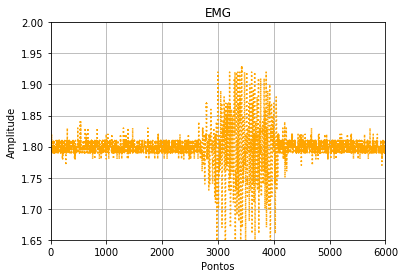

In [37]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(lines[0])))

plt.plot( x, lines[0], 'k:', color='orange') # linha pontilha orange

plt.axis([0, 6000, 1.65, 2])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

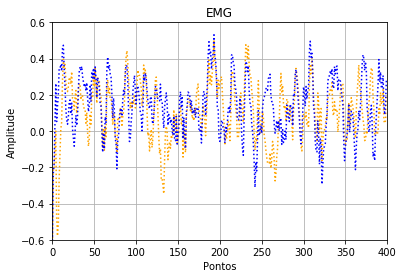

In [43]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(Part[0])))

plt.plot( x, media_linha_flexor, 'k:', color='orange') # linha pontilha orange
plt.plot( x, media_linha_flexor2, 'k:', color='blue')

plt.axis([0, 400, -0.6, 0.6])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

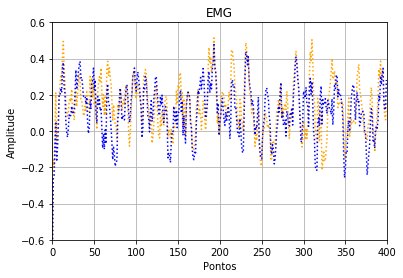

In [44]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(Part[0])))

plt.plot( x, media_linha_extensao, 'k:', color='orange') # linha pontilha orange
plt.plot( x, media_linha_extensao2, 'k:', color='blue')

plt.axis([0, 400,-0.6, 0.6])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

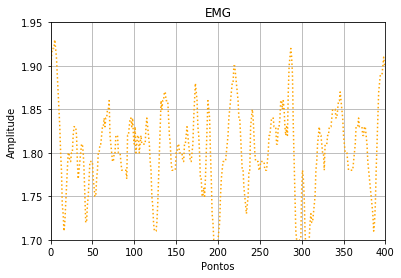

In [598]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(Part[10])))

plt.plot( x, Part[30], 'k:', color='orange') # linha pontilha orange

plt.axis([0, 400, 1.70, 1.95])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

# TREINO E TESTE

In [599]:
# Importando biblioteca de treino e teste
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
74,0.00,0.285714,0.333333,0.500,0.6,0.4,0.6,0.666667,0.705882,0.761905,...,0.541667,0.500000,0.633333,0.600000,0.642857,0.833333,1.000000,1.000000,0.954545,0.964286
61,0.00,0.142857,0.222222,0.125,0.3,0.1,0.1,0.250000,0.470588,0.476190,...,0.541667,0.464286,0.533333,0.500000,0.500000,0.500000,0.380952,0.363636,0.363636,0.500000
65,0.00,0.285714,0.444444,0.375,0.6,0.3,0.3,0.333333,0.529412,0.571429,...,0.583333,0.464286,0.500000,0.400000,0.464286,0.416667,0.333333,0.363636,0.454545,0.642857
50,0.25,0.714286,0.666667,0.875,0.8,0.7,0.5,0.666667,0.705882,0.714286,...,0.416667,0.392857,0.400000,0.366667,0.357143,0.416667,0.428571,0.545455,0.681818,0.821429
72,0.25,0.428571,0.333333,0.500,0.5,0.2,0.1,0.083333,0.352941,0.428571,...,0.541667,0.535714,0.566667,0.566667,0.571429,0.625000,0.476190,0.454545,0.500000,0.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.25,0.428571,0.444444,0.375,0.4,0.4,0.5,0.666667,0.705882,0.666667,...,0.541667,0.535714,0.633333,0.566667,0.535714,0.500000,0.428571,0.363636,0.409091,0.500000
67,0.50,0.428571,0.444444,0.375,0.7,0.8,0.7,0.666667,0.705882,0.666667,...,0.375000,0.392857,0.566667,0.433333,0.428571,0.541667,0.380952,0.409091,0.409091,0.571429
13,0.00,0.428571,0.555556,0.750,0.6,0.3,0.2,0.166667,0.235294,0.333333,...,0.791667,0.714286,0.766667,0.700000,0.821429,0.958333,0.904762,0.863636,0.772727,0.714286
77,0.00,0.428571,0.444444,0.500,0.6,0.6,0.6,0.750000,0.823529,0.904762,...,0.750000,0.750000,0.800000,0.733333,0.857143,0.916667,0.904762,0.909091,0.909091,1.000000


,0
74,1.0
61,1.0
65,1.0
50,0.0
72,1.0
...,...
60,1.0
67,1.0
13,0.0
77,1.0


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
66,0.25,0.571429,0.444444,0.875,0.7,0.8,0.9,0.750000,0.588235,0.523810,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,0.380952,0.136364,0.000000,0.000000
35,0.25,0.428571,0.555556,0.500,0.6,0.5,0.5,0.583333,0.705882,0.761905,...,0.666667,0.642857,0.733333,0.700000,0.714286,0.750000,0.619048,0.545455,0.590909,0.607143
8,0.25,0.571429,0.555556,0.625,0.6,0.3,0.1,0.000000,0.176471,0.238095,...,0.833333,0.678571,0.700000,0.600000,0.571429,0.500000,0.380952,0.363636,0.409091,0.500000
37,0.00,0.428571,0.333333,0.375,0.4,0.2,0.1,0.333333,0.529412,0.714286,...,0.708333,0.678571,0.700000,0.633333,0.714286,0.625000,0.523810,0.590909,0.590909,0.642857
18,0.50,0.714286,0.777778,0.875,0.8,0.5,0.3,0.333333,0.352941,0.380952,...,0.666667,0.607143,0.666667,0.666667,0.714286,0.750000,0.714286,0.727273,0.818182,0.821429
11,0.25,0.285714,0.333333,0.500,0.5,0.3,0.2,0.250000,0.352941,0.428571,...,0.791667,0.750000,0.800000,0.700000,0.642857,0.583333,0.380952,0.363636,0.363636,0.464286
51,0.25,0.285714,0.333333,0.625,0.8,0.6,0.6,0.750000,0.823529,0.809524,...,0.875000,0.750000,0.866667,0.866667,0.892857,0.833333,0.666667,0.454545,0.363636,0.321429
75,0.25,0.285714,0.333333,0.625,0.6,0.5,0.8,0.666667,0.705882,0.714286,...,0.666667,0.642857,0.733333,0.766667,0.750000,0.791667,0.714286,0.500000,0.590909,0.642857
28,0.00,0.285714,0.222222,0.000,0.2,0.0,0.1,0.416667,0.411765,0.571429,...,0.583333,0.571429,0.633333,0.633333,0.714286,0.791667,0.714286,0.636364,0.590909,0.535714
7,0.00,0.428571,0.333333,0.250,0.4,0.1,0.0,0.083333,0.411765,0.571429,...,0.416667,0.535714,0.700000,0.733333,0.750000,0.958333,0.952381,0.909091,0.818182,0.750000


,0
66,1.0
35,1.0
8,0.0
37,1.0
18,0.0
11,0.0
51,0.0
75,1.0
28,1.0
7,0.0


# REDE MLP

In [600]:
# Importar bibliotecas para criação do modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

# Criar rede MLP

model = Sequential()
model.add(Input(shape=(400,)))
model.add(Dense(400))
model.add(Dense(200))
model.add(Dense(100))
model.add(Dense(1, activation='sigmoid'))

model.summary()

#model.get_config()

#model.get_weights()


Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 400)               160400    
_________________________________________________________________
dense_198 (Dense)            (None, 200)               80200     
_________________________________________________________________
dense_199 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 101       
Total params: 260,801
Trainable params: 260,801
Non-trainable params: 0
_________________________________________________________________


In [601]:
# Definindo método de acurácia e perda
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [602]:
#Gerando o modelo fit

history = model.fit(X_train, y_train, batch_size=10, epochs=1000, validation_data=(X_test, y_test), verbose=2)

Train on 64 samples, validate on 16 samples
Epoch 1/1000
64/64 - 3s - loss: 1.8964 - acc: 0.4844 - val_loss: 0.7156 - val_acc: 0.4375
Epoch 2/1000
64/64 - 0s - loss: 0.9235 - acc: 0.5469 - val_loss: 0.9027 - val_acc: 0.5000
Epoch 3/1000
64/64 - 0s - loss: 0.6702 - acc: 0.5938 - val_loss: 0.8765 - val_acc: 0.5000
Epoch 4/1000
64/64 - 0s - loss: 0.6299 - acc: 0.6250 - val_loss: 0.8141 - val_acc: 0.5000
Epoch 5/1000
64/64 - 0s - loss: 0.7340 - acc: 0.5625 - val_loss: 0.7962 - val_acc: 0.5000
Epoch 6/1000
64/64 - 0s - loss: 0.5905 - acc: 0.6562 - val_loss: 0.7446 - val_acc: 0.4375
Epoch 7/1000
64/64 - 0s - loss: 0.5242 - acc: 0.8125 - val_loss: 0.9218 - val_acc: 0.4375
Epoch 8/1000
64/64 - 0s - loss: 0.5181 - acc: 0.7031 - val_loss: 0.9263 - val_acc: 0.5000
Epoch 9/1000
64/64 - 0s - loss: 0.4989 - acc: 0.7500 - val_loss: 0.8987 - val_acc: 0.3750
Epoch 10/1000
64/64 - 0s - loss: 0.5036 - acc: 0.7031 - val_loss: 1.9342 - val_acc: 0.5000
Epoch 11/1000
64/64 - 0s - loss: 0.9608 - acc: 0.5625 -

Epoch 91/1000
64/64 - 0s - loss: 6.6381e-04 - acc: 1.0000 - val_loss: 8.0794 - val_acc: 0.3750
Epoch 92/1000
64/64 - 0s - loss: 6.6963e-04 - acc: 1.0000 - val_loss: 7.9921 - val_acc: 0.3750
Epoch 93/1000
64/64 - 0s - loss: 6.1804e-04 - acc: 1.0000 - val_loss: 8.2363 - val_acc: 0.3750
Epoch 94/1000
64/64 - 0s - loss: 5.9436e-04 - acc: 1.0000 - val_loss: 8.1605 - val_acc: 0.3750
Epoch 95/1000
64/64 - 0s - loss: 5.6899e-04 - acc: 1.0000 - val_loss: 8.0174 - val_acc: 0.3750
Epoch 96/1000
64/64 - 0s - loss: 5.6313e-04 - acc: 1.0000 - val_loss: 8.1686 - val_acc: 0.3750
Epoch 97/1000
64/64 - 0s - loss: 5.2031e-04 - acc: 1.0000 - val_loss: 8.3264 - val_acc: 0.3750
Epoch 98/1000
64/64 - 0s - loss: 5.2362e-04 - acc: 1.0000 - val_loss: 8.2749 - val_acc: 0.3750
Epoch 99/1000
64/64 - 0s - loss: 4.9380e-04 - acc: 1.0000 - val_loss: 8.2661 - val_acc: 0.3750
Epoch 100/1000
64/64 - 0s - loss: 4.8231e-04 - acc: 1.0000 - val_loss: 8.3064 - val_acc: 0.3750
Epoch 101/1000
64/64 - 0s - loss: 4.6837e-04 - ac

Epoch 177/1000
64/64 - 0s - loss: 1.1780e-04 - acc: 1.0000 - val_loss: 9.8888 - val_acc: 0.3750
Epoch 178/1000
64/64 - 0s - loss: 1.1328e-04 - acc: 1.0000 - val_loss: 9.8782 - val_acc: 0.3750
Epoch 179/1000
64/64 - 0s - loss: 1.1129e-04 - acc: 1.0000 - val_loss: 9.8684 - val_acc: 0.3750
Epoch 180/1000
64/64 - 0s - loss: 1.1115e-04 - acc: 1.0000 - val_loss: 9.8686 - val_acc: 0.3750
Epoch 181/1000
64/64 - 0s - loss: 1.0941e-04 - acc: 1.0000 - val_loss: 9.8713 - val_acc: 0.3750
Epoch 182/1000
64/64 - 0s - loss: 1.0914e-04 - acc: 1.0000 - val_loss: 9.8885 - val_acc: 0.3750
Epoch 183/1000
64/64 - 0s - loss: 1.0807e-04 - acc: 1.0000 - val_loss: 9.9935 - val_acc: 0.3750
Epoch 184/1000
64/64 - 0s - loss: 1.0654e-04 - acc: 1.0000 - val_loss: 9.9756 - val_acc: 0.3750
Epoch 185/1000
64/64 - 0s - loss: 1.0463e-04 - acc: 1.0000 - val_loss: 9.9740 - val_acc: 0.3750
Epoch 186/1000
64/64 - 0s - loss: 1.0243e-04 - acc: 1.0000 - val_loss: 10.0036 - val_acc: 0.3750
Epoch 187/1000
64/64 - 0s - loss: 1.015

Epoch 262/1000
64/64 - 0s - loss: 4.5792e-05 - acc: 1.0000 - val_loss: 10.8410 - val_acc: 0.3750
Epoch 263/1000
64/64 - 0s - loss: 4.5282e-05 - acc: 1.0000 - val_loss: 10.8752 - val_acc: 0.3750
Epoch 264/1000
64/64 - 0s - loss: 4.5192e-05 - acc: 1.0000 - val_loss: 10.9064 - val_acc: 0.3750
Epoch 265/1000
64/64 - 0s - loss: 4.5275e-05 - acc: 1.0000 - val_loss: 10.9332 - val_acc: 0.3750
Epoch 266/1000
64/64 - 0s - loss: 4.4632e-05 - acc: 1.0000 - val_loss: 10.9218 - val_acc: 0.3750
Epoch 267/1000
64/64 - 0s - loss: 4.4157e-05 - acc: 1.0000 - val_loss: 10.8816 - val_acc: 0.3750
Epoch 268/1000
64/64 - 0s - loss: 4.3582e-05 - acc: 1.0000 - val_loss: 10.8960 - val_acc: 0.3750
Epoch 269/1000
64/64 - 0s - loss: 4.3586e-05 - acc: 1.0000 - val_loss: 10.8843 - val_acc: 0.3750
Epoch 270/1000
64/64 - 0s - loss: 4.3233e-05 - acc: 1.0000 - val_loss: 10.9024 - val_acc: 0.3750
Epoch 271/1000
64/64 - 0s - loss: 4.3120e-05 - acc: 1.0000 - val_loss: 10.9819 - val_acc: 0.3750
Epoch 272/1000
64/64 - 0s - lo

Epoch 347/1000
64/64 - 0s - loss: 2.3291e-05 - acc: 1.0000 - val_loss: 11.6033 - val_acc: 0.3750
Epoch 348/1000
64/64 - 0s - loss: 2.3186e-05 - acc: 1.0000 - val_loss: 11.6155 - val_acc: 0.3750
Epoch 349/1000
64/64 - 0s - loss: 2.3327e-05 - acc: 1.0000 - val_loss: 11.6344 - val_acc: 0.3750
Epoch 350/1000
64/64 - 0s - loss: 2.2914e-05 - acc: 1.0000 - val_loss: 11.6290 - val_acc: 0.3750
Epoch 351/1000
64/64 - 0s - loss: 2.2750e-05 - acc: 1.0000 - val_loss: 11.6209 - val_acc: 0.3750
Epoch 352/1000
64/64 - 0s - loss: 2.2490e-05 - acc: 1.0000 - val_loss: 11.6096 - val_acc: 0.3750
Epoch 353/1000
64/64 - 0s - loss: 2.2346e-05 - acc: 1.0000 - val_loss: 11.6190 - val_acc: 0.3750
Epoch 354/1000
64/64 - 0s - loss: 2.2259e-05 - acc: 1.0000 - val_loss: 11.6104 - val_acc: 0.3750
Epoch 355/1000
64/64 - 0s - loss: 2.2060e-05 - acc: 1.0000 - val_loss: 11.6311 - val_acc: 0.3750
Epoch 356/1000
64/64 - 0s - loss: 2.1936e-05 - acc: 1.0000 - val_loss: 11.6575 - val_acc: 0.3750
Epoch 357/1000
64/64 - 0s - lo

Epoch 432/1000
64/64 - 0s - loss: 1.3194e-05 - acc: 1.0000 - val_loss: 12.1824 - val_acc: 0.3750
Epoch 433/1000
64/64 - 0s - loss: 1.3359e-05 - acc: 1.0000 - val_loss: 12.1618 - val_acc: 0.3750
Epoch 434/1000
64/64 - 0s - loss: 1.3088e-05 - acc: 1.0000 - val_loss: 12.2145 - val_acc: 0.3750
Epoch 435/1000
64/64 - 0s - loss: 1.2979e-05 - acc: 1.0000 - val_loss: 12.2334 - val_acc: 0.3750
Epoch 436/1000
64/64 - 0s - loss: 1.3002e-05 - acc: 1.0000 - val_loss: 12.2257 - val_acc: 0.3750
Epoch 437/1000
64/64 - 0s - loss: 1.2851e-05 - acc: 1.0000 - val_loss: 12.2364 - val_acc: 0.3750
Epoch 438/1000
64/64 - 0s - loss: 1.2719e-05 - acc: 1.0000 - val_loss: 12.2160 - val_acc: 0.3750
Epoch 439/1000
64/64 - 0s - loss: 1.2759e-05 - acc: 1.0000 - val_loss: 12.2041 - val_acc: 0.3750
Epoch 440/1000
64/64 - 0s - loss: 1.2597e-05 - acc: 1.0000 - val_loss: 12.2332 - val_acc: 0.3750
Epoch 441/1000
64/64 - 0s - loss: 1.2537e-05 - acc: 1.0000 - val_loss: 12.2751 - val_acc: 0.3750
Epoch 442/1000
64/64 - 0s - lo

Epoch 517/1000
64/64 - 0s - loss: 8.1329e-06 - acc: 1.0000 - val_loss: 12.6947 - val_acc: 0.3750
Epoch 518/1000
64/64 - 0s - loss: 8.1250e-06 - acc: 1.0000 - val_loss: 12.6894 - val_acc: 0.3750
Epoch 519/1000
64/64 - 0s - loss: 8.0361e-06 - acc: 1.0000 - val_loss: 12.7073 - val_acc: 0.3750
Epoch 520/1000
64/64 - 0s - loss: 7.9716e-06 - acc: 1.0000 - val_loss: 12.7333 - val_acc: 0.3750
Epoch 521/1000
64/64 - 0s - loss: 7.9299e-06 - acc: 1.0000 - val_loss: 12.7269 - val_acc: 0.3750
Epoch 522/1000
64/64 - 0s - loss: 7.8741e-06 - acc: 1.0000 - val_loss: 12.7524 - val_acc: 0.3750
Epoch 523/1000
64/64 - 0s - loss: 7.8592e-06 - acc: 1.0000 - val_loss: 12.7701 - val_acc: 0.3750
Epoch 524/1000
64/64 - 0s - loss: 7.7855e-06 - acc: 1.0000 - val_loss: 12.7549 - val_acc: 0.3750
Epoch 525/1000
64/64 - 0s - loss: 7.7426e-06 - acc: 1.0000 - val_loss: 12.7495 - val_acc: 0.3750
Epoch 526/1000
64/64 - 0s - loss: 7.6970e-06 - acc: 1.0000 - val_loss: 12.7636 - val_acc: 0.3750
Epoch 527/1000
64/64 - 0s - lo

Epoch 602/1000
64/64 - 0s - loss: 5.1955e-06 - acc: 1.0000 - val_loss: 13.1737 - val_acc: 0.3750
Epoch 603/1000
64/64 - 0s - loss: 5.1486e-06 - acc: 1.0000 - val_loss: 13.1846 - val_acc: 0.3750
Epoch 604/1000
64/64 - 0s - loss: 5.1090e-06 - acc: 1.0000 - val_loss: 13.2012 - val_acc: 0.3750
Epoch 605/1000
64/64 - 0s - loss: 5.0816e-06 - acc: 1.0000 - val_loss: 13.2256 - val_acc: 0.3750
Epoch 606/1000
64/64 - 0s - loss: 5.0765e-06 - acc: 1.0000 - val_loss: 13.2364 - val_acc: 0.3750
Epoch 607/1000
64/64 - 0s - loss: 5.0468e-06 - acc: 1.0000 - val_loss: 13.2381 - val_acc: 0.3750
Epoch 608/1000
64/64 - 0s - loss: 5.0135e-06 - acc: 1.0000 - val_loss: 13.2368 - val_acc: 0.3750
Epoch 609/1000
64/64 - 0s - loss: 5.0623e-06 - acc: 1.0000 - val_loss: 13.2165 - val_acc: 0.3750
Epoch 610/1000
64/64 - 0s - loss: 4.9663e-06 - acc: 1.0000 - val_loss: 13.2411 - val_acc: 0.3750
Epoch 611/1000
64/64 - 0s - loss: 4.9328e-06 - acc: 1.0000 - val_loss: 13.2561 - val_acc: 0.3750
Epoch 612/1000
64/64 - 0s - lo

Epoch 687/1000
64/64 - 0s - loss: 3.4123e-06 - acc: 1.0000 - val_loss: 13.6541 - val_acc: 0.3750
Epoch 688/1000
64/64 - 0s - loss: 3.3984e-06 - acc: 1.0000 - val_loss: 13.6527 - val_acc: 0.3750
Epoch 689/1000
64/64 - 0s - loss: 3.3719e-06 - acc: 1.0000 - val_loss: 13.6468 - val_acc: 0.3750
Epoch 690/1000
64/64 - 0s - loss: 3.3685e-06 - acc: 1.0000 - val_loss: 13.6455 - val_acc: 0.3750
Epoch 691/1000
64/64 - 0s - loss: 3.3543e-06 - acc: 1.0000 - val_loss: 13.6624 - val_acc: 0.3750
Epoch 692/1000
64/64 - 0s - loss: 3.3303e-06 - acc: 1.0000 - val_loss: 13.6521 - val_acc: 0.3750
Epoch 693/1000
64/64 - 0s - loss: 3.3146e-06 - acc: 1.0000 - val_loss: 13.6587 - val_acc: 0.3750
Epoch 694/1000
64/64 - 0s - loss: 3.2964e-06 - acc: 1.0000 - val_loss: 13.6677 - val_acc: 0.3750
Epoch 695/1000
64/64 - 0s - loss: 3.2861e-06 - acc: 1.0000 - val_loss: 13.6845 - val_acc: 0.3750
Epoch 696/1000
64/64 - 0s - loss: 3.2633e-06 - acc: 1.0000 - val_loss: 13.6876 - val_acc: 0.3750
Epoch 697/1000
64/64 - 0s - lo

Epoch 772/1000
64/64 - 0s - loss: 2.3003e-06 - acc: 1.0000 - val_loss: 14.0898 - val_acc: 0.3750
Epoch 773/1000
64/64 - 0s - loss: 2.2850e-06 - acc: 1.0000 - val_loss: 14.0907 - val_acc: 0.3750
Epoch 774/1000
64/64 - 0s - loss: 2.2713e-06 - acc: 1.0000 - val_loss: 14.0827 - val_acc: 0.3750
Epoch 775/1000
64/64 - 0s - loss: 2.2555e-06 - acc: 1.0000 - val_loss: 14.0769 - val_acc: 0.3750
Epoch 776/1000
64/64 - 0s - loss: 2.2492e-06 - acc: 1.0000 - val_loss: 14.0726 - val_acc: 0.3750
Epoch 777/1000
64/64 - 0s - loss: 2.2674e-06 - acc: 1.0000 - val_loss: 14.0594 - val_acc: 0.3750
Epoch 778/1000
64/64 - 0s - loss: 2.2400e-06 - acc: 1.0000 - val_loss: 14.0869 - val_acc: 0.3750
Epoch 779/1000
64/64 - 0s - loss: 2.2170e-06 - acc: 1.0000 - val_loss: 14.1034 - val_acc: 0.3750
Epoch 780/1000
64/64 - 0s - loss: 2.2069e-06 - acc: 1.0000 - val_loss: 14.1175 - val_acc: 0.3750
Epoch 781/1000
64/64 - 0s - loss: 2.2049e-06 - acc: 1.0000 - val_loss: 14.1207 - val_acc: 0.3750
Epoch 782/1000
64/64 - 0s - lo

Epoch 857/1000
64/64 - 0s - loss: 1.5610e-06 - acc: 1.0000 - val_loss: 14.4569 - val_acc: 0.3750
Epoch 858/1000
64/64 - 0s - loss: 1.5533e-06 - acc: 1.0000 - val_loss: 14.4648 - val_acc: 0.3750
Epoch 859/1000
64/64 - 0s - loss: 1.5452e-06 - acc: 1.0000 - val_loss: 14.4747 - val_acc: 0.3750
Epoch 860/1000
64/64 - 0s - loss: 1.5461e-06 - acc: 1.0000 - val_loss: 14.5175 - val_acc: 0.3750
Epoch 861/1000
64/64 - 0s - loss: 1.5534e-06 - acc: 1.0000 - val_loss: 14.5417 - val_acc: 0.3750
Epoch 862/1000
64/64 - 0s - loss: 1.5371e-06 - acc: 1.0000 - val_loss: 14.5356 - val_acc: 0.3750
Epoch 863/1000
64/64 - 0s - loss: 1.5231e-06 - acc: 1.0000 - val_loss: 14.5268 - val_acc: 0.3750
Epoch 864/1000
64/64 - 0s - loss: 1.5169e-06 - acc: 1.0000 - val_loss: 14.5018 - val_acc: 0.3750
Epoch 865/1000
64/64 - 0s - loss: 1.5097e-06 - acc: 1.0000 - val_loss: 14.5063 - val_acc: 0.3750
Epoch 866/1000
64/64 - 0s - loss: 1.4971e-06 - acc: 1.0000 - val_loss: 14.4987 - val_acc: 0.3750
Epoch 867/1000
64/64 - 0s - lo

Epoch 942/1000
64/64 - 0s - loss: 1.0692e-06 - acc: 1.0000 - val_loss: 14.8745 - val_acc: 0.3750
Epoch 943/1000
64/64 - 0s - loss: 1.0732e-06 - acc: 1.0000 - val_loss: 14.9002 - val_acc: 0.3750
Epoch 944/1000
64/64 - 0s - loss: 1.0651e-06 - acc: 1.0000 - val_loss: 14.9033 - val_acc: 0.3750
Epoch 945/1000
64/64 - 0s - loss: 1.0574e-06 - acc: 1.0000 - val_loss: 14.8949 - val_acc: 0.3750
Epoch 946/1000
64/64 - 0s - loss: 1.0521e-06 - acc: 1.0000 - val_loss: 14.8900 - val_acc: 0.3750
Epoch 947/1000
64/64 - 0s - loss: 1.0520e-06 - acc: 1.0000 - val_loss: 14.8731 - val_acc: 0.3125
Epoch 948/1000
64/64 - 0s - loss: 1.0465e-06 - acc: 1.0000 - val_loss: 14.8780 - val_acc: 0.3125
Epoch 949/1000
64/64 - 0s - loss: 1.0487e-06 - acc: 1.0000 - val_loss: 14.9105 - val_acc: 0.3750
Epoch 950/1000
64/64 - 0s - loss: 1.0338e-06 - acc: 1.0000 - val_loss: 14.9197 - val_acc: 0.3750
Epoch 951/1000
64/64 - 0s - loss: 1.0412e-06 - acc: 1.0000 - val_loss: 14.9407 - val_acc: 0.3750
Epoch 952/1000
64/64 - 0s - lo

# SALVAR MODELO

# TESTANDO MODELO

In [603]:
prediction = model.predict(X_test)


display(prediction)
display(y_test)

array([[0.0000000e+00],
       [1.2790561e-03],
       [2.7979028e-01],
       [5.1856041e-06],
       [1.8485069e-02],
       [5.2168965e-04],
       [5.0137317e-01],
       [1.5100837e-04],
       [0.0000000e+00],
       [9.9960101e-01],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [6.1720610e-05],
       [1.5549958e-03],
       [0.0000000e+00]], dtype=float32)

,0
66,1.0
35,1.0
8,0.0
37,1.0
18,0.0
11,0.0
51,0.0
75,1.0
28,1.0
7,0.0


# OUTRO MODELO DE REDE